# Final AI Project

# Problem 

In a global marketplace, businesses often receive customer feedback in multiple languages through various audio channels, such as customer support calls, social media voice messages, and feedback surveys. Analyzing this multilingual audio feedback to extract actionable insights is a significant challenge. Businesses need to understand the sentiments, preferences, and concerns of a diverse customer base to make informed decisions that cater to a global audience.

# Solution

Automate the extraction, transcription, translation, analysis, and visualization of multilingual customer feedback from audio files to efficiently identify customer sentiment and key insights across different markets. This involves several key steps:

**Transcribing Audio to Text**: Utilize Speech-to-Text services to convert audio feedback into text, allowing for the processing of large volumes of audio data.

**Translating Multilingual Feedback**: Apply Translation services to translate the transcribed text into a common language (e.g., English), ensuring that the sentiment analysis can be performed uniformly across feedback from different languages.

**Analyzing Sentiment**: Employ Sentiment Analysis with Natural Language Processing (NLP) tools to evaluate the sentiment (positive, negative, neutral) of the translated feedback. This step is crucial for gauging customer satisfaction levels and identifying areas for improvement.

In [49]:
#Import necessary libraries

import os
import pprint
from google.cloud import storage
from google.cloud import speech
from google.cloud import translate_v2 as translate
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import urllib.parse
import requests
import json
import pandas as pd
from google.cloud import language_v1
import os
import numpy as np
import uuid
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [37]:
# Set the environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "service-account.json"

In [38]:
# Initialize the translation client
translate_client = translate.Client()

In [39]:
# Initialize the sentiment analysis client
client = language_v1.LanguageServiceClient()

In [40]:
#Transcribes audio from a Google Cloud Storage URI using Google Cloud Speech-to-Text.
#Returns the transcription response containing the text and confidence scores.

def extract_audio_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri and returns transcriptions with confidence scores."""
    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        audio_channel_count=2,
        language_code="fr",
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=1000)

    return response

In [41]:
#Translates text to a target language using Google Cloud Translation.
#Returns the translated text.

def translate_text(text, target_language='en'):
    # Translates the text
    translation = translate_client.translate(text, target_language=target_language)

    translated_text = translation['translatedText']

    return translated_text

In [42]:
#Analyzes the sentiment of a given text using Google Cloud Natural Language API.
#Returns the sentiment score and magnitude.

def sentimental_analysis(text):
    document = language_v1.types.Document(content=text, type_=language_v1.types.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={"document": document}).document_sentiment
    return sentiment.score, sentiment.magnitude


In [43]:
#Lists all the blobs (files) in the specified Google Cloud Storage bucket.
#Returns an iterator over the blobs.

def list_blobs(bucket_name):
    """Lists all the blobs in the given bucket."""
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name)
    return blobs

In [44]:
#Main function to process audio files from a specified Google Cloud Storage bucket.
#Extracts, transcribes, translates, and analyzes sentiment of audio content, storing the results.
#Returns a list of dictionaries with data about each processed audio segment.

def main():
    bucket_name = "final_assignment_marketing"
    blobs = list_blobs(bucket_name)
    
    data_list = []

    for blob in blobs:
        gcs_uri = "gs://" + bucket_name + "/" + blob.name
        response = extract_audio_gcs(gcs_uri=gcs_uri)
        
        sentence_number_counter = 1
        for result in response.results:
            for alternative in result.alternatives:
                translated_text = translate_text(alternative.transcript)
                sentiment_score, sentiment_magnitude = sentimental_analysis(translated_text)
                
                data = {
                    "wav_filename": 'French Audio',
                    "sentence_number": sentence_number_counter,
                    "sentence_text": translated_text,
                    "sentiment": sentiment_score,
                    "magnitude": sentiment_magnitude,
                    "transcription_date": datetime.now().strftime("%Y-%m-%d"),
                    "transcription_confidence": alternative.confidence,
        
                }
                data_list.append(data)
                sentence_number_counter += 1

    return data_list


In [45]:
if __name__ == "__main__":
    
    data_list = main()

    # Convert data_list to a DataFrame
    df = pd.DataFrame(data_list)

    # Print the DataFrame
    print("Data in DataFrame format:")
    print(df)

Waiting for operation to complete...
Data in DataFrame format:
    wav_filename  sentence_number  \
0   French Audio                1   
1   French Audio                2   
2   French Audio                3   
3   French Audio                4   
4   French Audio                5   
5   French Audio                6   
6   French Audio                7   
7   French Audio                8   
8   French Audio                9   
9   French Audio               10   
10  French Audio               11   
11  French Audio               12   
12  French Audio               13   
13  French Audio               14   

                                        sentence_text  sentiment  magnitude  \
0   telephone consultation with customer service w...       -0.2        0.2   
1    I would like to speak to a customer service r...       -0.5        0.5   
2    check your account I do see additional charge...       -0.7        0.7   
3    I see and what is the cost of these internati...       -0.4 

In [46]:
df


,wav_filename,sentence_number,sentence_text,sentiment,magnitude,transcription_date,transcription_confidence
0,French Audio,1,telephone consultation with customer service w...,-0.2,0.2,2024-03-04,0.937995
1,French Audio,2,I would like to speak to a customer service r...,-0.5,0.5,2024-03-04,0.931844
2,French Audio,3,check your account I do see additional charge...,-0.7,0.7,2024-03-04,0.934747
3,French Audio,4,I see and what is the cost of these internati...,-0.4,0.4,2024-03-04,0.933820
4,French Audio,5,would you like to upgrade to this package wou...,-0.3,0.3,2024-03-04,0.933702
5,French Audio,6,from next month your new package including in...,0.7,0.7,2024-03-04,0.931356
6,French Audio,7,thus staying in contact with your family abro...,0.8,0.8,2024-03-04,0.932467
7,French Audio,8,today I am going to make a video in French ab...,-0.4,0.4,2024-03-04,0.934109
8,French Audio,9,I&#39;m calling you because I received my tel...,-0.6,0.6,2024-03-04,0.933717
9,French Audio,10,nationals have you made calls abroad recently...,-0.7,0.7,2024-03-04,0.931428


In [60]:
def connect_to_db():
    
    with open("pass.txt") as f:
        password = f.read()
    """Connect to the database."""
    mydb = mysql.connector.connect(
        host="localhost",
        user="admn5015",
        password=password,
        database="sentiment_analysis_database"
    )

    return mydb


In [66]:
def insert_data(df):
    """Insert data from DataFrame into MySQL database."""
    # Connect to the database
    mydb = connect_to_db()
    cursor = mydb.cursor()

    # Adjust the number of placeholders (%s) to match the number of columns in your DataFrame
    # Here, we dynamically create the placeholders string based on the DataFrame's columns
    placeholders = ", ".join(["%s"] * len(df.columns))

    # SQL INSERT query
    insert_query = f"INSERT INTO sentiment_analysis ({', '.join(df.columns)}) VALUES ({placeholders})"

    # Loop through DataFrame rows and execute the query
    for _, row in df.iterrows():
        # Convert row to tuple
        data_tuple = tuple(row)
        
        # Execute the query
        cursor.execute(insert_query, data_tuple)

    # Commit the changes
    mydb.commit()

    # Close the cursor and the connection
    cursor.close()
    mydb.close()




In [68]:
# Call the function to insert the data
insert_data(df)

In [70]:
df.to_excel('SQL_data.xlsx')

# Visualization

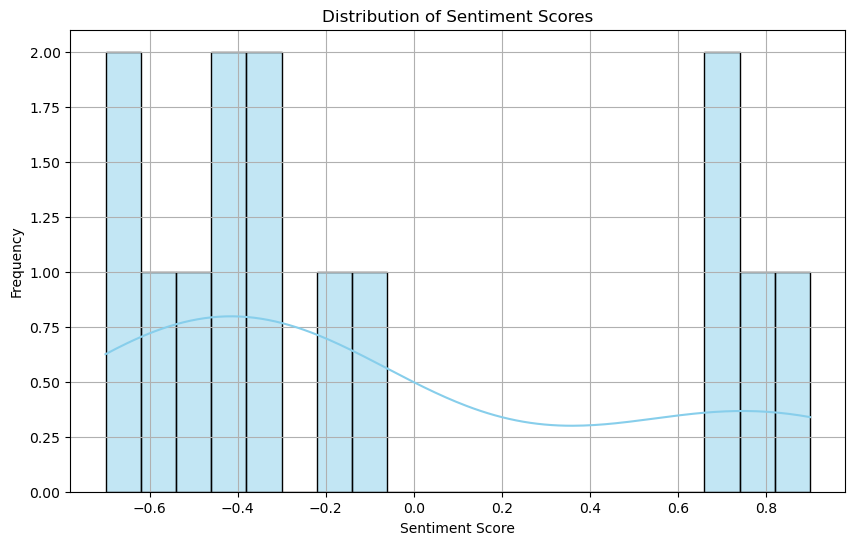

Overall Average Sentiment: -0.08
Overall Average Transcription Confidence: 0.93
Proportion of Positive Feedback: 28.57%
Proportion of Neutral Feedback: 0.00%
Proportion of Negative Feedback: 71.43%


In [74]:
df['transcription_date'] = pd.to_datetime(df['transcription_date'])

# Confidence Score Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, color='skyblue', kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Summary Statistics
# Overall average sentiment
average_sentiment = df['sentiment'].mean()

# Overall average transcription confidence
average_confidence = df['transcription_confidence'].mean()

# Display summary statistics
print(f"Overall Average Sentiment: {average_sentiment:.2f}")
print(f"Overall Average Transcription Confidence: {average_confidence:.2f}")

# Calculate and display the proportion of positive, neutral, and negative sentiments
positive_proportion = (df['sentiment'] > 0).mean()
neutral_proportion = (df['sentiment'] == 0).mean()
negative_proportion = (df['sentiment'] < 0).mean()

print(f"Proportion of Positive Feedback: {positive_proportion:.2%}")
print(f"Proportion of Neutral Feedback: {neutral_proportion:.2%}")
print(f"Proportion of Negative Feedback: {negative_proportion:.2%}")


**Distribution of Sentiment Scores**:

The histogram shows a distribution of sentiment scores that leans towards negative values, indicating that a significant portion of the customer feedback is negative. This suggests areas of service or product that may need improvement.

The presence of both positive and negative sentiment scores highlights the diversity in customer feedback, emphasizing the need for detailed analysis to address specific concerns.